In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr

import sys
sys.path.append('../..')

from utils.workflow import WorkflowModel
import utils.plotting as plotting
from utils.eval import eval_predictions

2026-02-20 11:14:34.259914: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-20 11:14:34.298267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-20 11:14:35.737503: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


E0000 00:00:1771596878.678444  789482 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1771596878.685078  789482 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
df = pd.read_csv("../../data/sir-am-7d.csv")
df[:5]

,I
0,1185.428571
1,1309.714286
2,1454.857143
3,1627.428571
4,1838.428571


In [3]:
I_data = df["I"].to_numpy()
I_data[:5]

array([1185.42857143, 1309.71428571, 1454.85714286, 1627.42857143,
       1838.42857143])

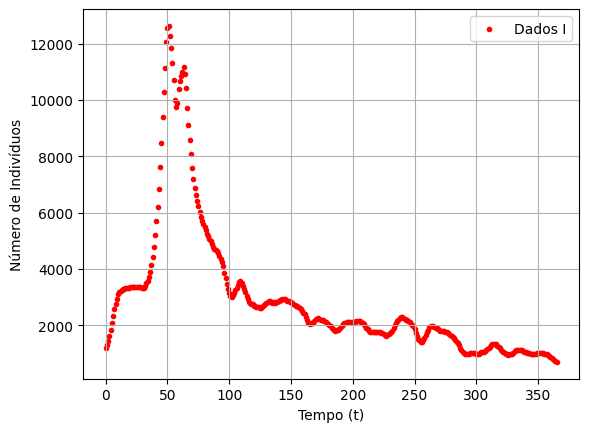

In [4]:
t_0, t_f = 0, len(I_data) - 1
data_t = np.linspace(t_0, t_f, len(I_data))
plotting.plot_prevalence_data(data_t, I_data, "incidence-data-am-2023")

In [ ]:
N = 8116132 # population size
gamma = 1/7

In [ ]:
model = WorkflowModel(t_0, t_f, I_data, data_t, N, gamma, 
    activation="tanh",
    n_hidden_layers=3,
    hidden_layer_size=80,
    w_physics=10,
    w_beta_smoothness=1, 
    scaling="min/max",
    estimate_beta=True,
    beta_estimation_window=5,
    adaptative_wdata=False,
    early_stopping=False)

Compiling model...
'compile' took 0.007068 s



In [7]:
model.S0, model.I0, model.beta0 

(np.float64(679.8633920984284),
 np.float64(0.04112359819515754),
 np.float64(0.2523377216470364))

In [8]:
model.train()

(<deepxde.model.LossHistory at 0x7fa8b4f7e5d0>,
 <deepxde.model.TrainState at 0x7fa8b4fbc310>)

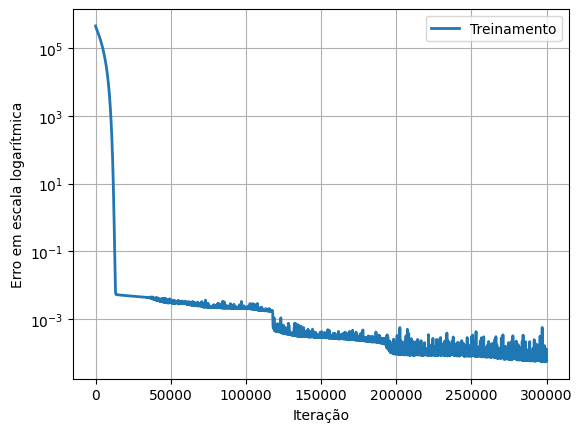

In [9]:
plotting.plot_losshistory(model.losshistory, "loss-am-2023")

In [10]:
test_t = np.linspace(t_0, t_f, 50)
pred = model.predict(test_t)

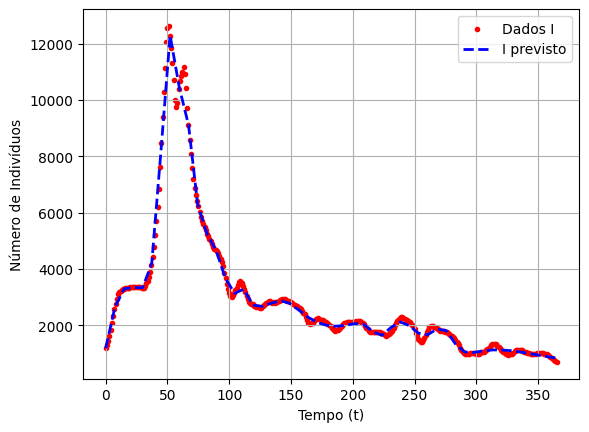

In [12]:
plotting.plot_prevalence_results(I_data, data_t, pred[:,1:2], test_t, "incidence-results-am-2023")

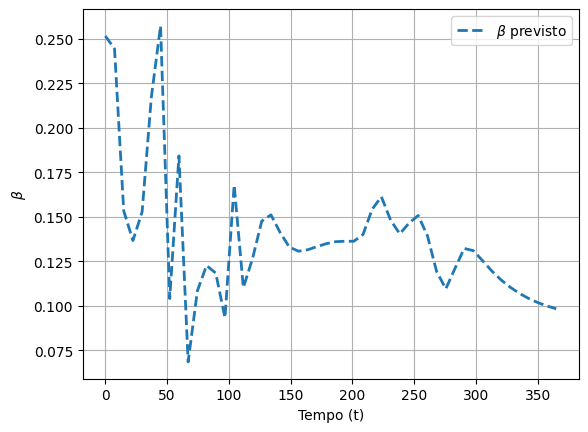

In [14]:
plotting.plot_beta_prediction(pred[:,2], test_t, figname="beta-am-2023")

In [15]:
pred_eval = model.predict(data_t)
eval_predictions(I_data.reshape(-1,1), pred_eval[:,1].reshape(-1,1), ["I"])

,compartiment,RMSE,L2,L-infinity
0,I,86.231121,0.022614,274.359507


In [16]:
model.formated_total_training_time

'01:20:02'

In [ ]:
humidity = pd.read_csv("../../data/daily_mean_humidity.csv")
humidity_values = humidity.to_numpy()[:,1].astype("float64")

In [ ]:
humidity_max, humidity_min = humidity_values.max(), humidity_values.min() 
# humidity_values = (humidity_values - humidity_min) / (humidity_max - humidity_min)
# humidity_values = humidity["0"].rolling(window=30).mean().dropna() 

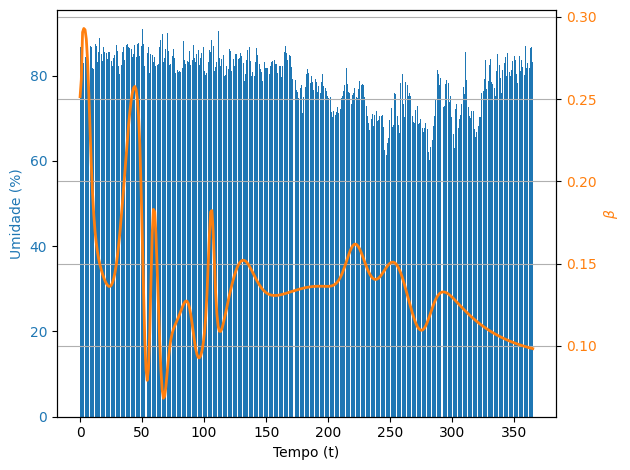

In [58]:
correlation_t = np.linspace(t_0, t_f, len(humidity_values))
pred_beta_correlation = model.predict(correlation_t)[:,2]

plotting.plot_correlation(
    pred_beta_correlation, 
    humidity_values, 
    correlation_t, 
    "Umidade (%)",
    "beta-humidity-correlation"
)

In [59]:
pearson_test = pearsonr(pred_beta_correlation, humidity_values)
pearson_test.statistic, pearson_test.pvalue

AttributeError: 'numpy.dtypes.ObjectDType' object has no attribute 'dtype'

In [53]:
spearman_test = spearmanr(pred_beta_correlation, humidity_values)
spearman_test.statistic, spearman_test.pvalue

(np.float64(0.14813105927389864), np.float64(0.004916928460762266))